In [1]:
# For Matrix Operations
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [2]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    
  return persistence
def Get_Vinyard(f, g, D, t = 101):
##########
    # input:
        # f and g by which you want to interpolate using straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,t)
    # creates homology from f to g using these intervals
    hs = np.array([(t * f) + (1-t) * g for t in ts])
    
    PDD = [persistence(h,dimension = D) for h in hs]

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

    mx = 'hey'
    #mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs
def Plot_Vinyard(res, mx, hs):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            
            v += f(D)*l*dt
            L += l*dt

        v *= g(L)
        V += v

    return V
def fD(D):
    return D/100
def fL(L):
    return 1


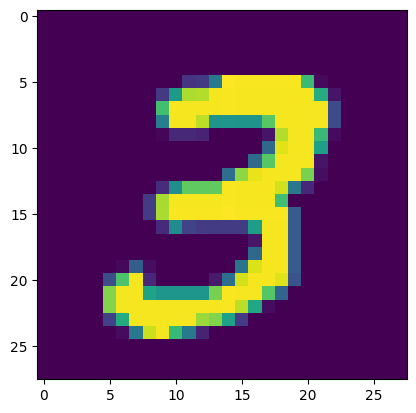

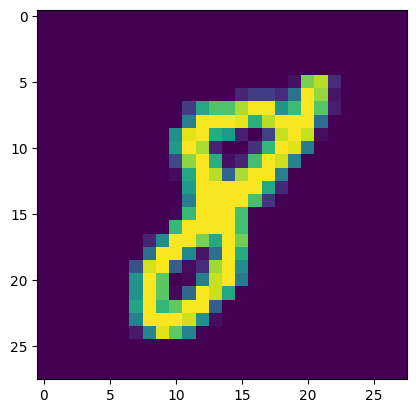

In [3]:
# fetching Mnist, finding a three and a eight. Creating an f and g for our test:

X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)
# X is 70000 images, y is the classifications
X.shape
# taking each image and turning it into a 3d array. Each slide is a 28 by 28 grayscale grid

X = X.reshape(X.shape[0],28,28)

# finding all the 6's and 9's and filtering them out
Threes = X[np.where(y == '3')]
Eights = X[np.where(y == '8')]

# can change this to a Nine if we want a Nine
f = Threes[0]

g = Eights[0]

# our first 6
plt.imshow(f)
plt.show()

# our first 9
plt.imshow(g)
plt.show()


In [4]:
no_samples = 100
Threes_Test = Threes[:no_samples]
Eights_Test = Eights[:no_samples]
Combined_Array = np.concatenate((Threes_Test, Eights_Test), axis = 0)

## L2 Distance Clustering

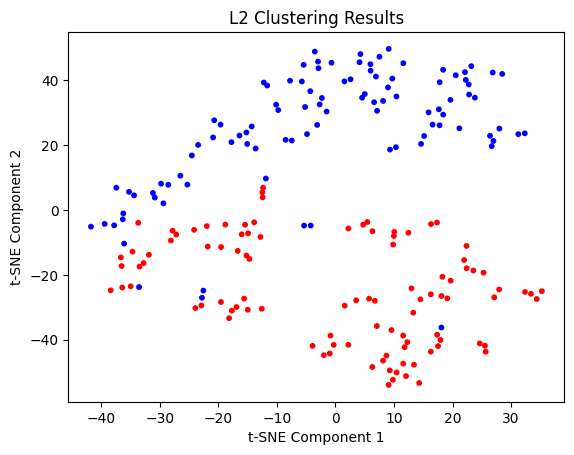

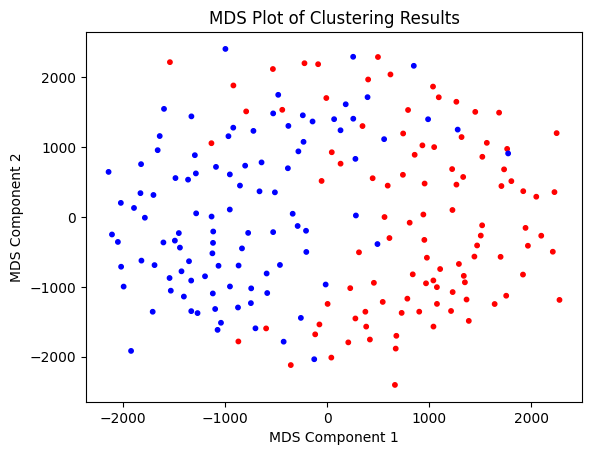

In [5]:
L2_Distances = np.zeros((len(Combined_Array), len(Combined_Array)))

for i in range(len(Combined_Array)):
    for j in range(i + 1, len(Combined_Array)):
        L2_Distances[i][j] = np.linalg.norm(Combined_Array[i] - Combined_Array[j])
L2_Distances += L2_Distances.transpose()

L2_Embedding = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(L2_Distances)


# Plotting TSNE
fig, ax = plt.subplots()

scatter = ax.scatter(L2_Embedding[:, 0], L2_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)


plt.title('L2 Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

L2_MDS_Embedding = MDS(n_components = 2, metric = True, dissimilarity = 'precomputed', random_state = 1).fit_transform(L2_Distances)


# Plotting TSNE
fig, ax = plt.subplots()

scatter = ax.scatter(L2_MDS_Embedding[:, 0], L2_MDS_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)


plt.title('MDS Plot of Clustering Results')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.show()


## Wasserstein Distance Clustering

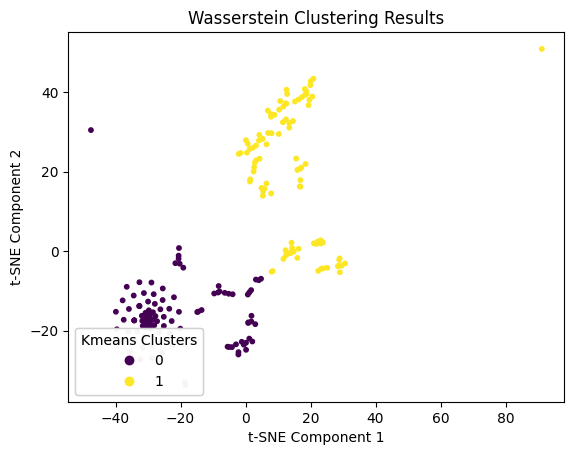

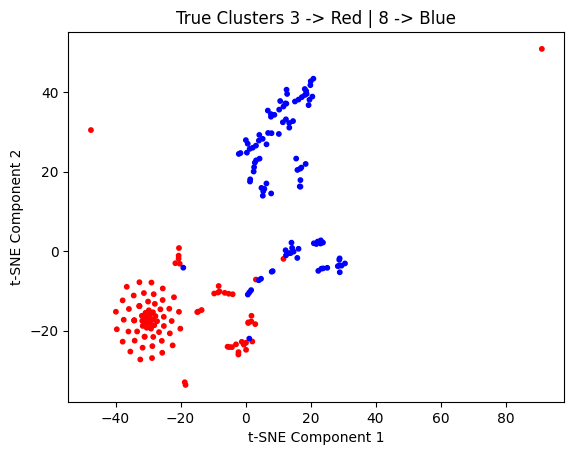

hey we got 191 correct


In [6]:
Threes_PDD = [persistence(Three, 1) for Three in Threes_Test]
Eights_PDD = [persistence(Eight, 1) for Eight in Eights_Test]

Threes_PDD.extend(Eights_PDD)
Total_PDD = Threes_PDD

# making distance matrix
W_Distances = np.zeros((len(Total_PDD), len(Total_PDD)))

for i in range(len(Total_PDD)):
    for j in range(len(Total_PDD)):
        W_Distances[i,j] = gudhi.hera.wasserstein_distance(Total_PDD[i], Total_PDD[j])

Wasserstein_Embedding = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(W_Distances)

# Perform KMeans clustering on the MDS embedding
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(Wasserstein_Embedding)

fig, ax = plt.subplots()

scatter = ax.scatter(Wasserstein_Embedding[:, 0], Wasserstein_Embedding[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Kmeans Clusters")
ax.add_artist(legend1)
plt.title('Wasserstein Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


fig, ax = plt.subplots()

scatter = ax.scatter(Wasserstein_Embedding[:, 0], Wasserstein_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)


plt.title('True Clusters 3 -> Red | 8 -> Blue')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

true_labels = np.concatenate((np.zeros((1,no_samples)),np.ones((1,no_samples))), axis = 1)
kmeans.labels_
correct_pairs = np.sum(true_labels[0] == kmeans.labels_)
print('hey we got {} correct'.format(str(correct_pairs)))

## Vinyard Distance Clustering

In [7]:
# Computing Vinyard Distances
Vinyard_Distances = np.zeros((Combined_Array.shape[0], Combined_Array.shape[0]))

for i in range(Combined_Array.shape[0]):
    for j in range(i+1,Combined_Array.shape[0]):
        Vinyard_Distances[i,j] = vdist(Get_Vinyard(Combined_Array[i], Combined_Array[j],0, t = 25)[0],fD,fL)
Vinyard_Distances += np.transpose(Vinyard_Distances)

Vinyard_Embedding = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Vinyard_Distances)


kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(Vinyard_Embedding)


# Plotting kmeans clusters

fig, ax = plt.subplots()

scatter = ax.scatter(Vinyard_Embedding[:, 0], Vinyard_Embedding[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Kmeans Clusters")
ax.add_artist(legend1)

plt.title('Vinyard Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

# Plotting true clusters

plt.scatter(Vinyard_Embedding[:, 0], Vinyard_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)

plt.title('Vinyard Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

# counting correct matches
true_labels = np.concatenate((np.zeros((1,no_samples)),np.ones((1,no_samples))), axis = 1)
kmeans.labels_
correct_pairs = np.sum(true_labels[0] == kmeans.labels_)
print('hey we got {} correct'.format(str(correct_pairs)))

: 